In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, ZeroPadding2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from simple_movement import DataGen, SimpleMovement

Using TensorFlow backend.


In [2]:
BASE_PATH = 'C:\\Users\\ttanj\\UoB\\WS18\\DBM\\data\data_simple_movement'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 2
RGB = 0

In [3]:
def mmc(x):
    df = 1 / 5
    w = np.array([
        [1, df, 0], [-1, 0, 1], [0, 0, 1]
    ])
    # w = np.identity(3)
    return K.dot(x, K.constant(w))

In [4]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='relu')(x)

x = Reshape((3*3*1,))(x)
x = Dense(3, activation='relu')(x)
x = Lambda(mmc)(x)
x = Dense(3*3*1, activation='relu')(x)
x = Reshape((3, 3, 1))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = ZeroPadding2D((1, 1))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [5]:
dgen = DataGen(HEIGHT, WIDTH, NUM_CHANNEL)
x, y = dgen.prepare_data(8)

x = x / 255.
y = y / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=331)

autoencoder.fit(x_train, y_train,
                epochs=200,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 86 samples, validate on 10 samples
Epoch 1/200
86/86 [==============================] - 9s 109ms/step - loss: 0.6832 - val_loss: 0.6639
Epoch 2/200
86/86 [==============================] - 5s 58ms/step - loss: 0.6347 - val_loss: 0.5763
Epoch 3/200
86/86 [==============================] - 5s 59ms/step - loss: 0.4951 - val_loss: 0.3558
Epoch 4/200
86/86 [==============================] - 5s 61ms/step - loss: 0.2747 - val_loss: 0.2423
Epoch 5/200
86/86 [==============================] - 5s 60ms/step - loss: 0.2432 - val_loss: 0.2218
Epoch 6/200
86/86 [==============================] - 5s 63ms/step - loss: 0.2166 - val_loss: 0.2142
Epoch 7/200
86/86 [==============================] - 5s 61ms/step - loss: 0.2141 - val_loss: 0.2129
Epoch 8/200
86/86 [==============================] - 5s 60ms/step - loss: 0.2128 - val_loss: 0.2120
Epoch 9/200
86/86 [==============================] - 5s 63ms/step - loss: 0.2120 - val_loss: 0.2111
Epoch 10/200
86/86 [==============================] - 5

In [6]:
decoded_imgs = autoencoder.predict(x_test)

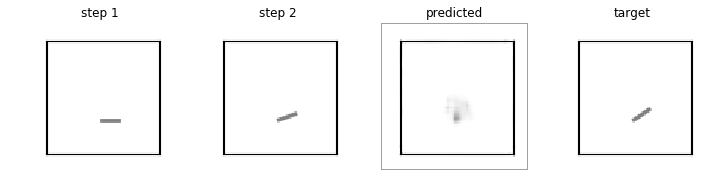

In [7]:
idx = 3

plt.figure(figsize=(10, 3))

# display original
ax = plt.subplot(1, 4, 1)
ax.imshow(x_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('step 1')

ax = plt.subplot(1, 4, 2)
ax.imshow(x_test[idx][:, :, 1].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('step 2')

# display reconstruction
ax = plt.subplot(1, 4, 3)
ax.imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('predicted')

ax = plt.subplot(1, 4, 4)
ax.imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('target')

plt.tight_layout()